In [1]:
%load_ext ipycache

C:\Users\jetbrains\Anaconda2\lib\site-packages\IPython\config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
C:\Users\jetbrains\Anaconda2\lib\site-packages\IPython\utils\traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from matplotlib import colors as clrs
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.manifold import TSNE

from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import multivariate_normal
from scipy.stats import laplace
from scipy.spatial.distance import cdist

from sklearn.metrics.pairwise import check_pairwise_arrays
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import mahalanobis

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

%matplotlib inline

In [3]:
print plotly.__version__

2.0.8


# word2vec

Run the dataset reading, parsing and word2vec learning

In [ ]:
%%cache w2v.pkl model
%run Word2Vec-test

C:\Users\jetbrains\Anaconda2\lib\site-packages\gensim\utils.py:860: UserWarning:

detected Windows; aliasing chunkize to chunkize_serial



In [6]:
word_vectors = model.wv.syn0
print word_vectors.shape

(5057L, 300L)


# k-means++

In [48]:
class KMeans(object):

    def __init__(self, n_components = 2, epsilon=0.01):
        self.n_components = n_components
        self.mu =[]
        self.epsilon = epsilon

    def _get_random_point(self, X):
        return X[np.random.choice (X.shape[0], 1)[0]]

    def get_cluster_means(self, X, y):
        labs = np.arange (self.n_components)
        mu = [np.mean(X[np.where(y == lab)], axis = 0) if np.array(np.where(y == lab)).size > 0 else self._get_random_point(X) for lab in labs]
        return mu

    def update_encoder(self, X, mu):
        self.y = [np.argmin(euclidean_distances(x.reshape(1, -1), mu)) for x in X]
        return self.y
    
    def _choice_with_probabilities(self, choice_probabilities):
        p_sum = sum(choice_probabilities)
        q = random.random() * p_sum
        for i in range(len(choice_probabilities)):
            if q < choice_probabilities[i]:
                return i
            else:
                q = q - choice_probabilities[i]
                
    def _d2(self, i, j, v):
        return cdist(v[i], v[j])[0][0] ** 2
    
    # The k-means++ initialization phase
    def _init_mu(self, X):
        reshaped = [x.reshape(1, -1) for x in X]
        first = self._choice_with_probabilities([1 for x in reshaped])
        l = len(reshaped)
        self.mu_indices = [first]
        chosen = [False for i in range(l)]
        d_square = [self._d2(first, i, reshaped) for i in range(l)]
        for i in range(self.n_components - 1):
            if i % 100 == 0: print 'Choosing center %s' % i
            next_item = self._choice_with_probabilities(d_square)
            chosen[next_item] = True
            d_square = [0 if chosen[i] else min(self._d2(i, next_item, reshaped), d_square[i]) for i in range(l)]
            self.mu_indices.append(next_item)
        self.mu = [X[i] for i in self.mu_indices]
                    
    def fit(self, X, y=None, n_iter=10):
        n = X.shape[0]
        labs = np.arange(self.n_components)
        self._init_mu(X)
        self.update_encoder(X, self.mu)
        self.cost = []
        for i in range(n_iter):
            print "iter %s" % i
            self.share = np.array([np.array(np.where(self.y == lab)).size for lab in labs])
            self.mu = self.get_cluster_means(X, self.y)
            self.cost.append(np.sum([(cdist(x.reshape(1, -1), self.mu)).min() for x in X]))
            self.y = self.update_encoder(X, self.mu)
            if i > 1 and np.abs(self.cost[-1] - self.cost[-2]) < self.epsilon: break;
        self.y = np.array(self.y)
        return self

    def predict(self, X):
        return np.array (self.update_encoder (X, self.mu))

Select **k**: use the number of words divided by 5 as a good heuristic:

In [8]:
n_centers = word_vectors.shape[0] / 5

In [9]:
%%cache kmns.pkl kmeans

print 'k = %s' % n_centers
kmeans = KMeans(n_components=n_centers)
kmeans.fit(word_vectors, n_iter=100);

[Skipped the cell's code and loaded variables kmeans from file 'C:\Users\jetbrains\IPythonNotebooks\kmns.pkl'.]
k = 1011
Choosing center 0
Choosing center 100
Choosing center 200
Choosing center 300
Choosing center 400
Choosing center 500
Choosing center 600
Choosing center 700
Choosing center 800
Choosing center 900
Choosing center 1000
iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9


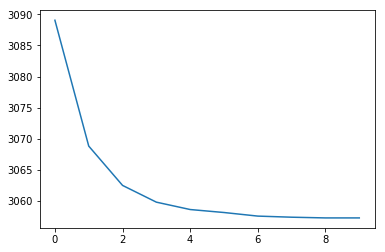

In [10]:
plt.plot(kmeans.cost);

# t-SNE

In [11]:
%%cache tsne.pkl wv2

compressor = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
wv2 = compressor.fit_transform(word_vectors) 

[Skipped the cell's code and loaded variables wv2 from file 'C:\Users\jetbrains\IPythonNotebooks\tsne.pkl'.]


# Visualization

In [12]:
plotly.offline.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='hotkeytlt', api_key='o9qMxhgAtufM2rDnYtI3')
colors = [np.random.uniform(100) for i in range(n_centers)]

In [84]:
def scatter_plot(xs, ys, labels, text, save_to_file=None, hide_labels=False, opacities=None, sizes=None):
    n = len(xs)
    point_colors = [colors[labels[i]] * 100 for i in range(n)]
    point_symbols = [labels[i] % 20 for i in range(n)]
    trace = go.Scatter(
        x = xs,
        y = ys,
        mode = 'markers+text' if not hide_labels else 'markers',
        text = text,
        marker = dict(
            color=point_colors,
            colorscale='Rainbow',
            size=sizes,
            opacity=opacities,
            symbol=point_symbols,
        ),
        textfont=dict(
            family='sans serif',
            size=10,
        )
    )
    data = [trace]
    if save_to_file is None:
        layout = go.Layout(hovermode = 'closest')
        fig = go.Figure(data=data, layout=layout)
        return plotly.offline.iplot(fig)
    else:
        layout = go.Layout(title=save_to_file, width=10000, height=6000)
        fig = go.Figure(data=data, layout=layout)
        py.image.save_as(fig, filename=save_to_file)

In [70]:
wxs = np.array(wv2).T[0]
wys = np.array(wv2).T[1]

Save the large image into file:

In [71]:
scatter_plot(wxs, wys, kmeans.y, 
             ['%s/%s' % (model.wv.index2word[i], kmeans.y[i]) for i in range(len(wxs))],
             'scatter_clusters.png')

Plot the words clustering inline:

In [15]:
scatter_plot(wxs, wys, kmeans.y, 
             ['%s/%s' % (model.wv.index2word[i], kmeans.y[i]) for i in range(len(wxs))], hide_labels=True)

**Evaluate and plot original k-means++ cluster centers:**

Number of initial centers that were merged into a single cluster:

In [79]:
len(kmeans.mu_indices) - len(set([kmeans.y[m] for m in kmeans.mu_indices]))

4

In [18]:
c_xs = [wxs[i] for i in kmeans.mu_indices]
c_ys = [wys[i] for i in kmeans.mu_indices]
c_ls = [kmeans.y[i] for i in kmeans.mu_indices]
scatter_plot(c_xs, c_ys, c_ls, 
             ['%s/%s' % (model.wv.index2word[i], kmeans.y[i]) for i in kmeans.mu_indices], hide_labels=True)

Find the cluster by word:

In [52]:
the_word = 'mr'

In [53]:
word_index = [i for i in range(len(model.wv.index2word)) if model.wv.index2word[i] == the_word]
the_cluster_id = kmeans.y[word_index]
the_cluster_word_indices = [i for i in range(len(kmeans.y)) if kmeans.y[i] == the_cluster_id]
print [model.wv.index2word[i] for i in the_cluster_word_indices]

[u'mr', u'jack', u'tom', u'joe', u'bill', u'harry', u'martin', u'billy', u'steve', u'mike', u'jim', u'dennis', u'eddie', u'jerry', u'johnny', u'chuck', u'jeff', u'jimmy', u'quaid', u'burt', u'doc', u'daniels', u'murray', u'carrey', u'hopper', u'reynolds', u'randy']


In [54]:
scatter_plot(wxs, wys, kmeans.y, 
             ['%s/%s' % (model.wv.index2word[i], kmeans.y[i]) for i in range(len(wxs))], hide_labels=True,
            opacities=[1.0 if i in the_cluster_word_indices else 0.4 for i in range(len(wxs))],
            sizes=[12.0 if i in the_cluster_word_indices else 6.0 for i in range(len(wxs))])